In [37]:
import pandas as pd
import seaborn as sns
import numpy as np
import requests
from matplotlib import pyplot as plt
from datetime import datetime
from io import BytesIO

### Fetch Data & Setup Dataframe

In [38]:
DATA_URL = 'https://www.cer-rec.gc.ca/open/energy/energyfutures2023/crude-oil-production-2023.csv'
cer_crude = None

# fetch data from GOC and load it into pandas dataframe
response = requests.get(DATA_URL)
with BytesIO(response.content) as data:
    cer_crude = pd.read_csv(data)

# Filter out unwanted column 
cer_crude.drop('Unnamed: 0', axis=1, inplace=True)
cer_crude.head(10)

,Scenario,Unit,Region,Variable,Year,Value
0,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2005,522.196657
1,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2006,619.063422
2,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2007,652.181177
3,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2008,620.080057
4,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2009,722.489601
5,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2010,702.550381
6,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2011,810.225803
7,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2012,817.105135
8,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2013,835.131864
9,Canada Net-zero,Thousand Barrels per day,Alberta,(Upgraded Bitumen),2014,842.494692


### Helper Functions

In [79]:
def create_line_graph(data, x, y, hue, title, y_label, caption, yticks, subtitle='', grouping=False, group_name='', legend_n_cols=1) -> None:
    '''
    Creates and shows a line graph based on the above parameters.
    This function will create a line graph based on any arbritrary data.
    '''
    # color and size
    palette = sns.color_palette("viridis", n_colors=data[hue].nunique())
    plt.figure(figsize=(10, 8))

    # plot the line based on grouping
    if grouping:
        sns.lineplot(data=data, x=x, y=y, hue=hue, style=group_name, dashes=True, palette=palette)
    else:
        sns.lineplot(data=data, x=x, y=y, hue=hue, palette=palette)

    # add title and subtitle
    plt.gca().text(0, 1.07, title, transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom', ha='left')
    if subtitle:
        plt.gca().text(0, 1.05, subtitle, transform=plt.gca().transAxes, verticalalignment='top', ha='left')
        
    # format axes
    plt.ylabel(y_label)
    plt.xlabel('')
    plt.yticks(yticks)

    # create and position legend
    bbox_to_anchor = (0.5 if not grouping else 0.25, -0.10)
    plt.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor, ncol=legend_n_cols)

    # caption/source text
    plt.text(x=1, y=-0.3 if not grouping else -0.4, s=caption, transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=12)
    
    # display final graph
    plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()


def create_stacked_area_chart(data, x, y, hue, title, y_label, caption, yticks, 
                              subtitle='', legend_n_cols=1, facet_by=None, facet_cols=1):
    '''
    Creates and shows a stacked area chart based on the above parameters.
    If `facet_by` is provided, it will create faceted plots based on that column.
    '''
    
    # Define the plotting function
    def stacked_plot(x, y, hue, **kwargs):
        # The data for this particular facet is now available as kwargs['data']
        facet_data = kwargs['data']

        # Fetch unique hue categories and their respective colors
        unique_hues = facet_data[hue].unique()
        palette = sns.color_palette("viridis", n_colors=len(unique_hues))

        # Prepare data for stacked area chart in reversed order
        layers = [facet_data[facet_data[hue] == category][y].values for category in reversed(unique_hues)]

        # Plot stacked area chart
        x_values = facet_data[x].unique()
        plt.stackplot(x_values, *layers, labels=reversed(unique_hues), colors=palette, alpha=0.6)

        # Format axes
        plt.ylabel(y_label)
        plt.xlabel('')
        plt.yticks(yticks)
    
    # Create the FacetGrid if faceting is required
    if facet_by:
        # Check the number of facets
        if len(facet_by) == 1:
            g = sns.FacetGrid(data, col=facet_by[0], col_wrap=len(data[facet_by[0]].unique()), height=8)
        elif len(facet_by) == 2:
            g = sns.FacetGrid(data, col=facet_by[0], row=facet_by[1], height=8)
        else:
            raise ValueError("The function currently supports up to 2 faceting variables. You provided more.")
        
        g.map_dataframe(stacked_plot, x, y, hue)
        g.set_titles(col_template="{col_name}", row_template="{row_name}")
        
        # Add title and subtitle
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(title)
            
        # Create and position legend
        bbox_to_anchor = (0.5, -0.10)
        plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
        plt.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor, ncol=legend_n_cols)
        
    else:
        plt.figure(figsize=(10, 8))
        stacked_plot(x, y, hue, data=data)
        
        # Add title and subtitle
        plt.gca().text(0, 1.07, title, transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom', ha='left')
        if subtitle:
            plt.gca().text(0, 1.05, subtitle, transform=plt.gca().transAxes, verticalalignment='top', ha='left')
        
        # Create and position legend
        bbox_to_anchor = (0.5, -0.10)
        plt.legend(loc='upper center', bbox_to_anchor=bbox_to_anchor, ncol=legend_n_cols)

    # Caption/source text (only if not faceted)
    plt.text(x=1, y=-0.4, s=caption, transform=plt.gca().transAxes, ha='right', va='bottom', fontsize=12)

    # Display final graph
    plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

### Introductory Graphs - Bitumen Production

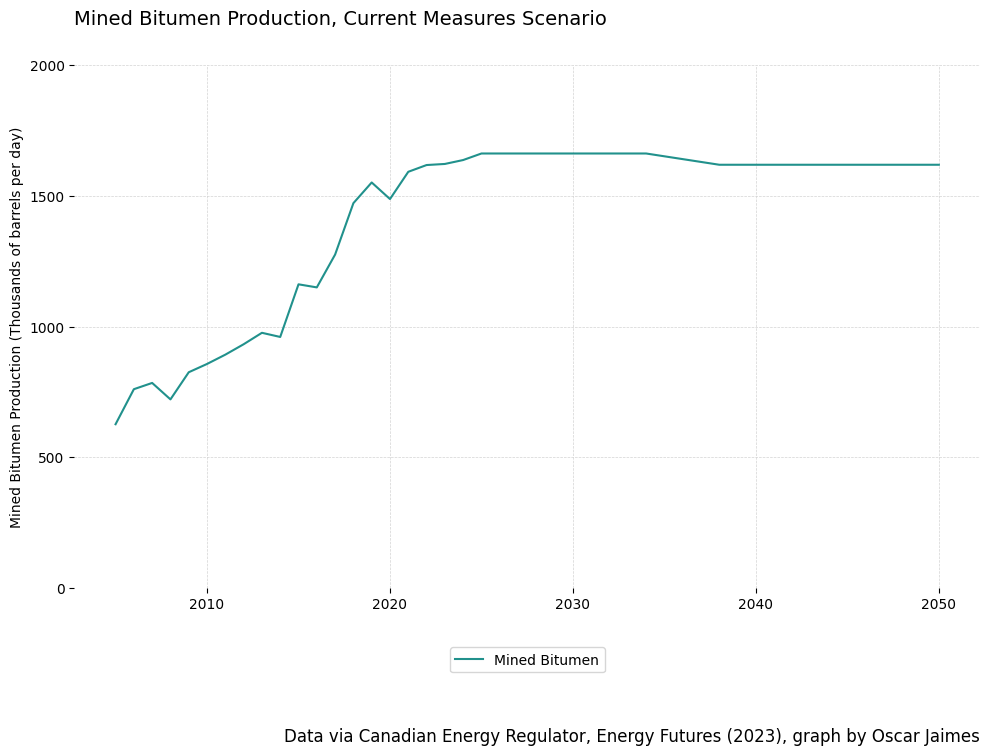

In [40]:
data = cer_crude[
    (cer_crude['Region'] == 'Canada') &
    (cer_crude['Unit'] == 'Thousand Barrels per day') &
    (cer_crude['Variable'] == 'Mined Bitumen') &
    (cer_crude['Scenario'] == 'Current Measures')
]


create_line_graph(
    data=data,
    x='Year',
    y='Value',
    hue='Variable',
    title='Mined Bitumen Production, Current Measures Scenario',
    y_label='Mined Bitumen Production (Thousands of barrels per day)',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(2001) if n % 500 == 0],
    subtitle=None,
    legend_n_cols=3,
    grouping=False,
    group_name=None
)

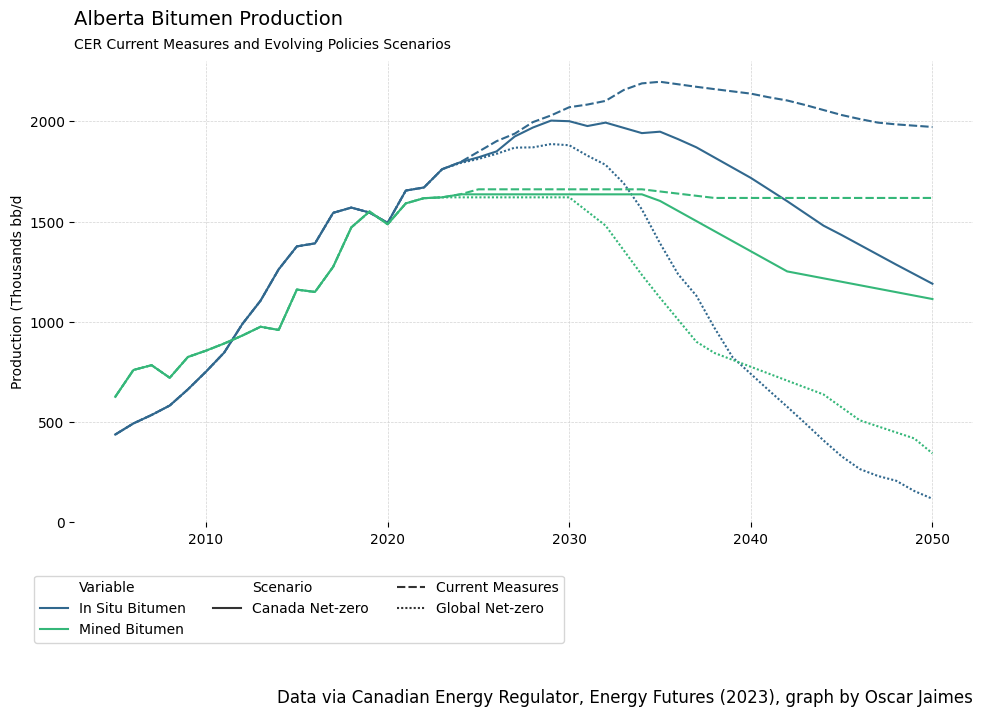

In [41]:
data = cer_crude[
    (cer_crude['Region'] == 'Alberta') &
    (cer_crude['Unit'] == 'Thousand Barrels per day') &
    (cer_crude['Variable'].isin(['In Situ Bitumen', 'Mined Bitumen']))
]

create_line_graph(
    data=data,
    x='Year',
    y='Value',
    hue='Variable',
    title='Alberta Bitumen Production',
    subtitle='CER Current Measures and Evolving Policies Scenarios',
    y_label='Production (Thousands bb/d',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(2001) if n % 500 == 0],
    grouping=True,
    group_name='Scenario',
    legend_n_cols=3
)

### Area Charts

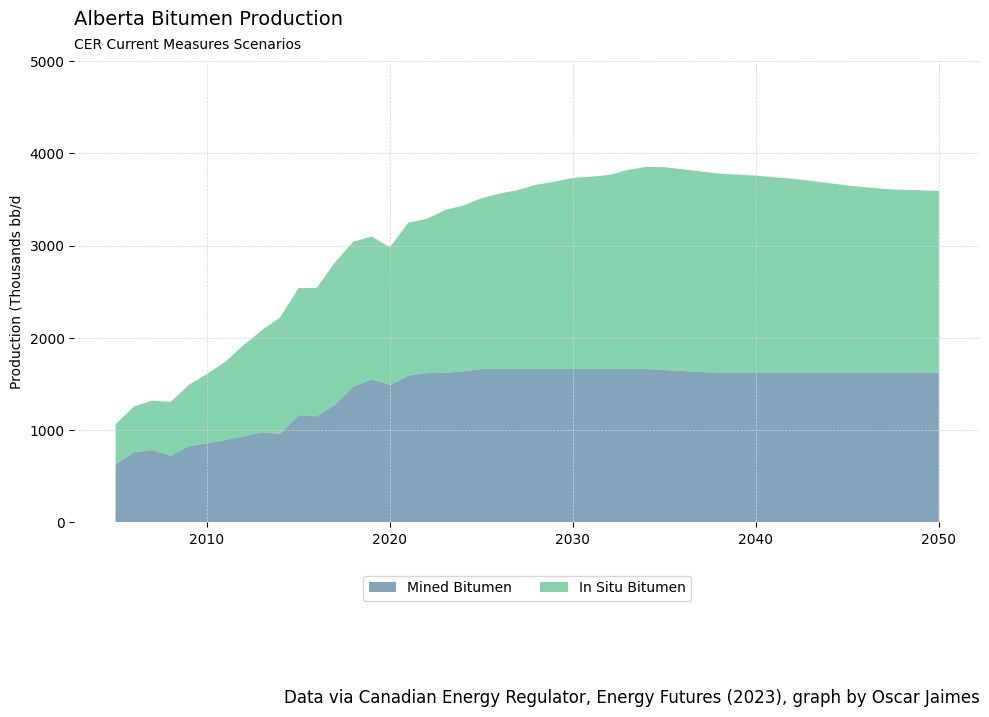

In [66]:
data = cer_crude[
    (cer_crude['Region'] == 'Alberta') &
    (cer_crude['Unit'] == 'Thousand Barrels per day') &
    (cer_crude['Variable'].isin(['In Situ Bitumen', 'Mined Bitumen'])) & 
    (cer_crude['Scenario'] == 'Current Measures')
]

create_stacked_area_chart(
    data=data,
    x='Year',
    y='Value',
    hue='Variable',
    title='Alberta Bitumen Production',
    subtitle='CER Current Measures Scenarios',
    y_label='Production (Thousands bb/d',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(5001) if n % 1000 == 0],
    legend_n_cols=3
)

### Faceted Plots

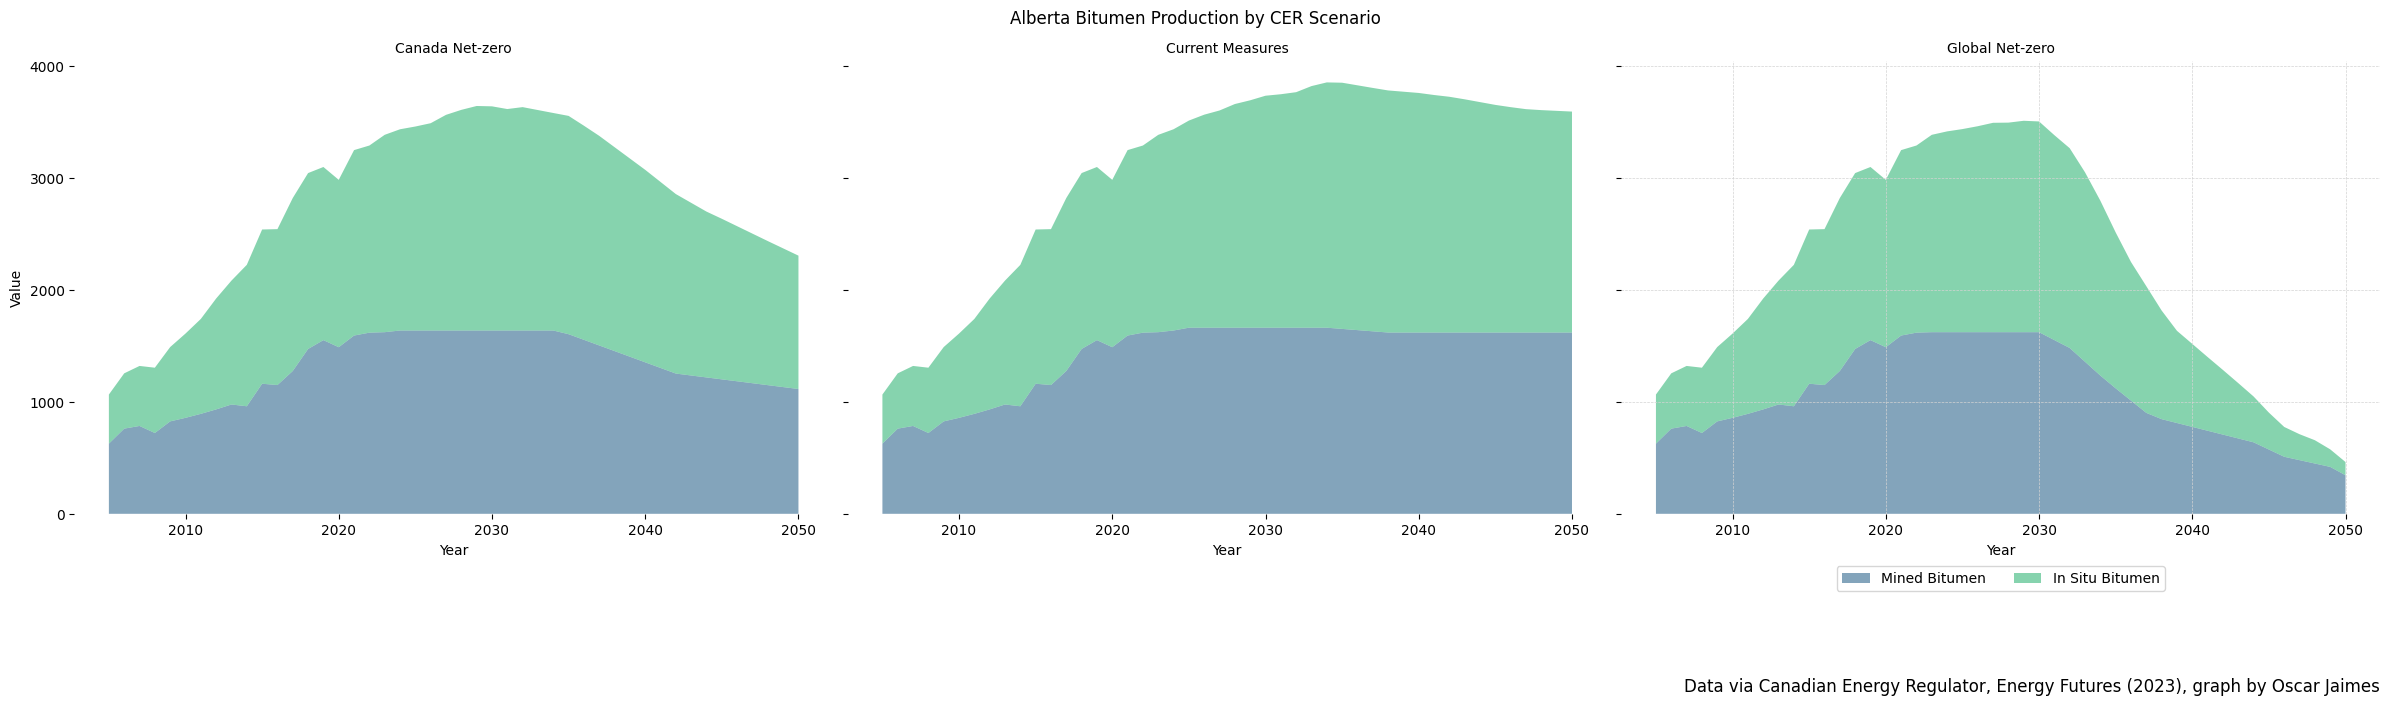

In [77]:
data = cer_crude[
    (cer_crude['Region'] == 'Alberta') &
    (cer_crude['Unit'] == 'Thousand Barrels per day') &
    (cer_crude['Variable'].isin(['In Situ Bitumen', 'Mined Bitumen'])) 
]

create_stacked_area_chart(
    data=data,
    x='Year',
    y='Value',
    hue='Variable',
    title='Alberta Bitumen Production by CER Scenario',
    subtitle='CER Current Measures Scenario',
    y_label='Production (Thousands bb/d)',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(4001) if n % 1000 == 0],
    legend_n_cols=3,
    facet_by=['Scenario']
)

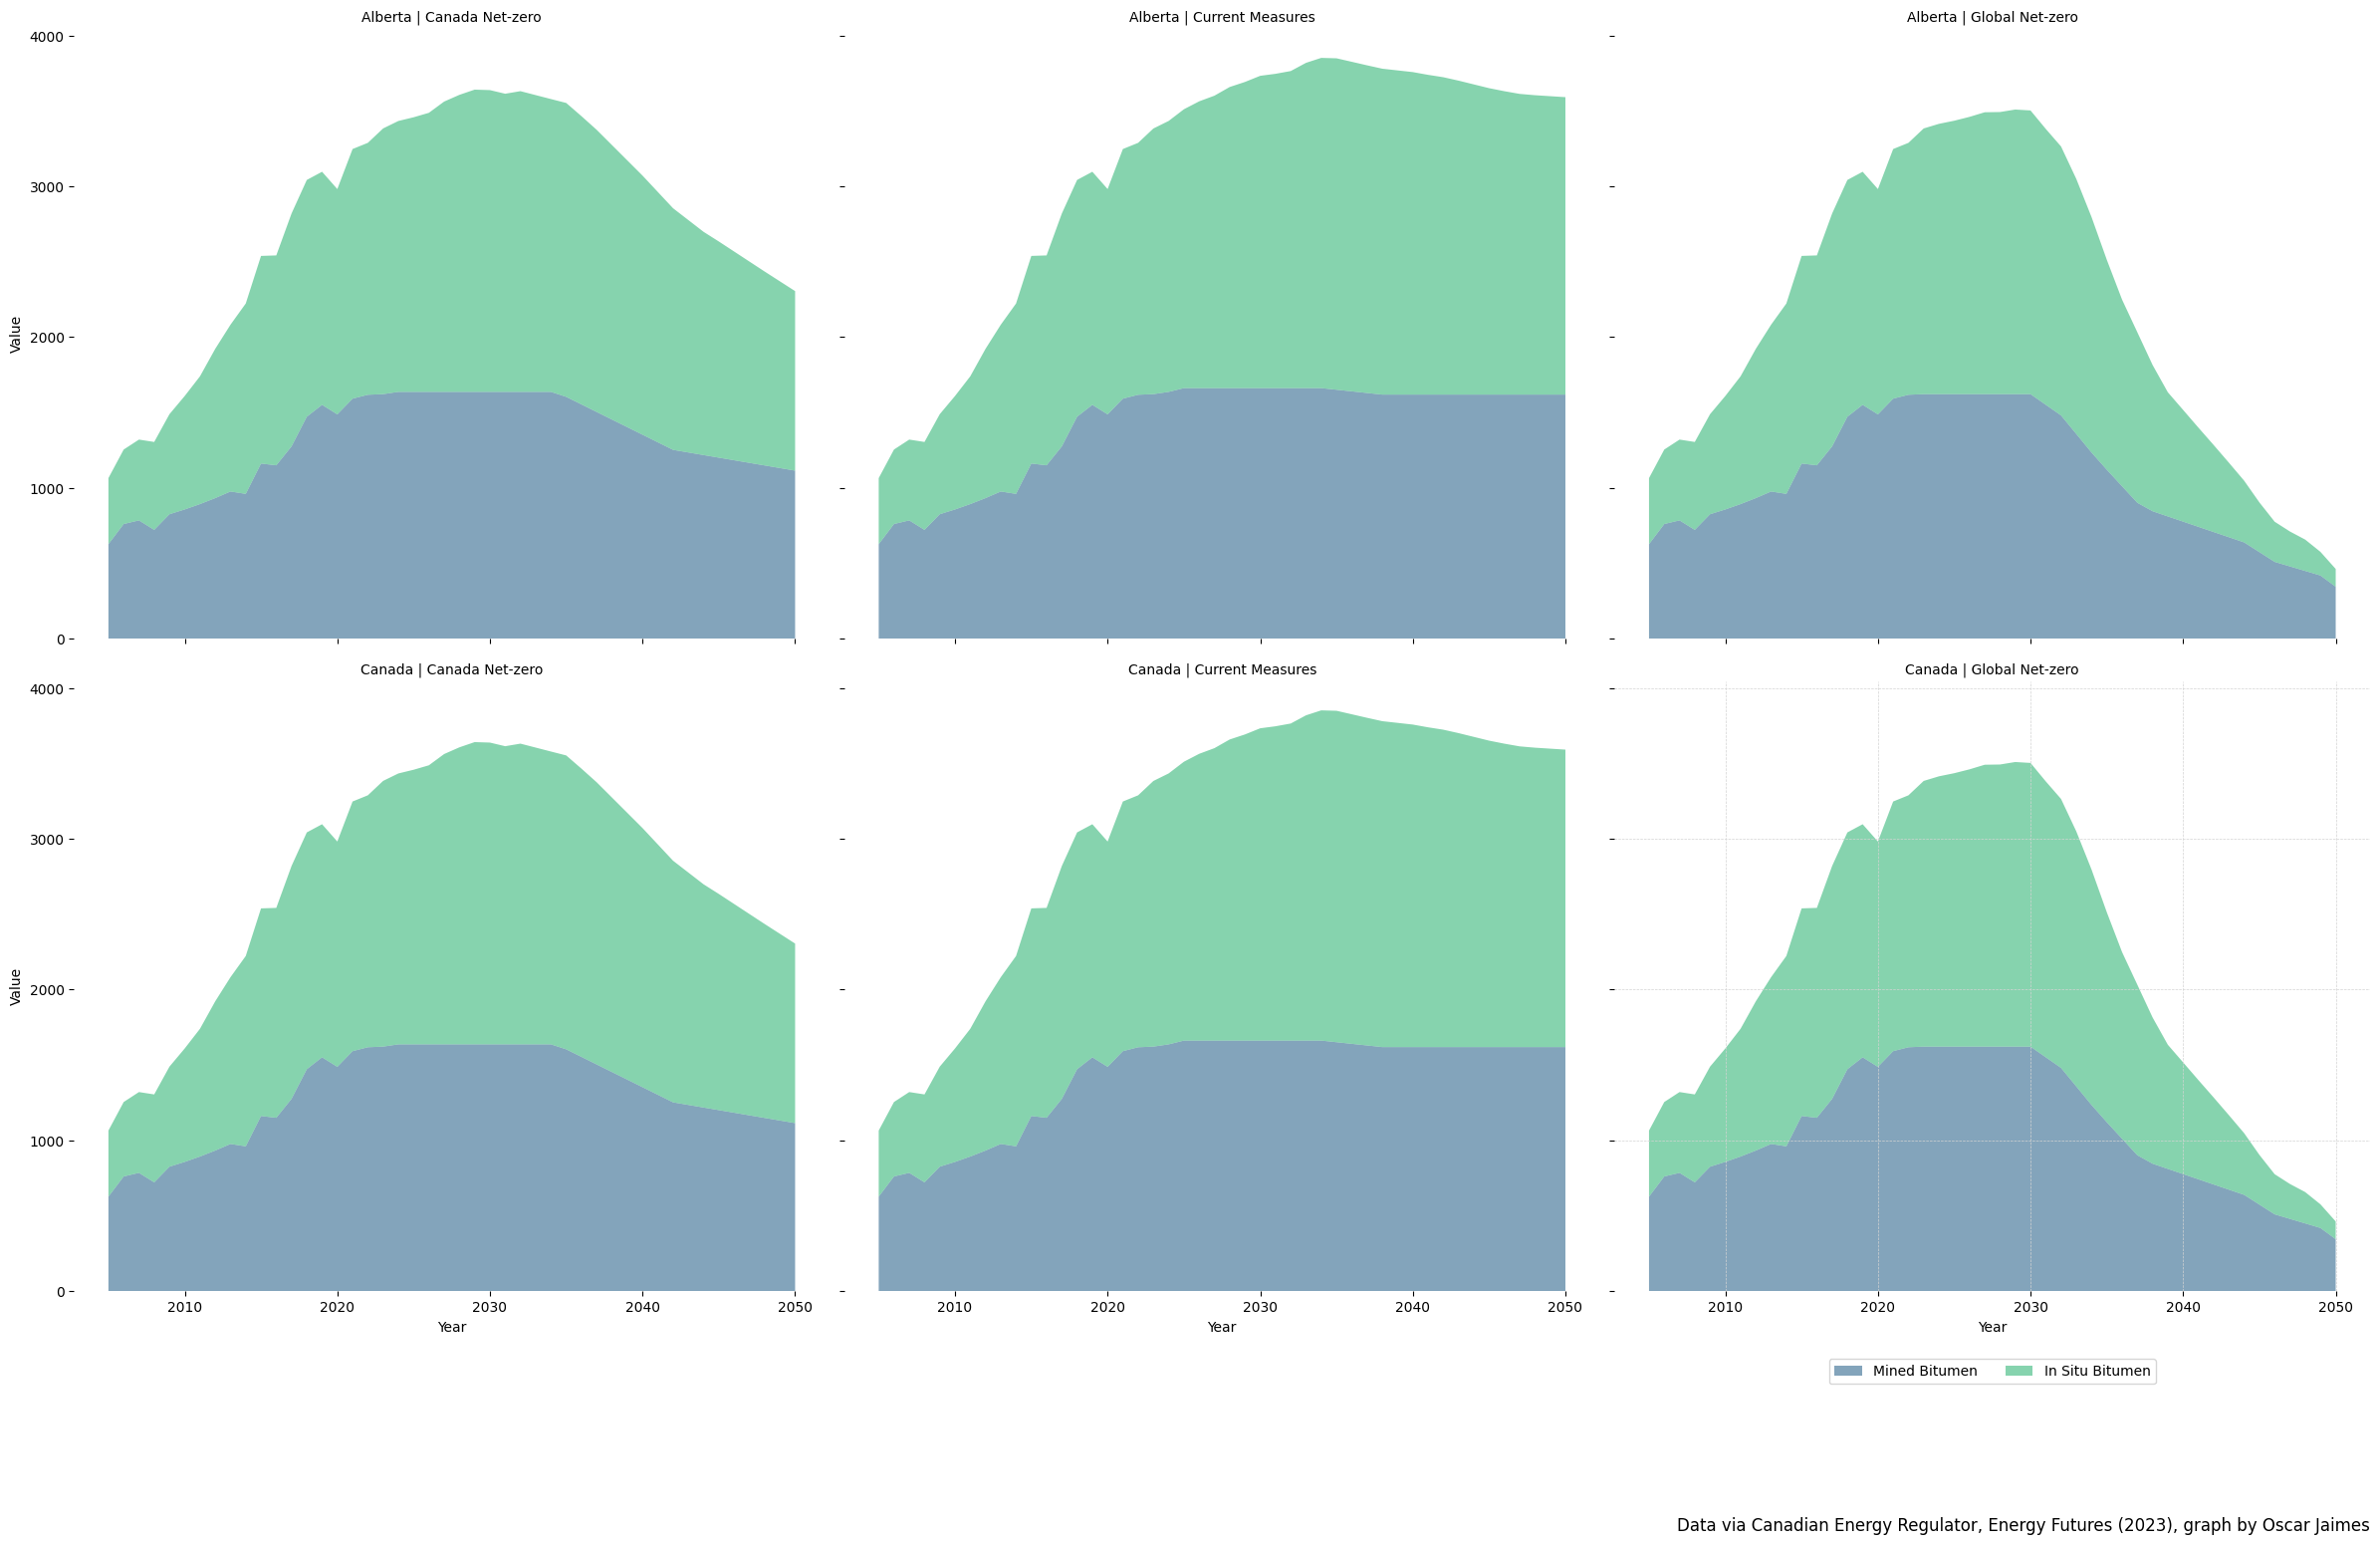

In [83]:
data = cer_crude[
    (cer_crude['Unit'] == 'Thousand Barrels per day') &
    (cer_crude['Variable'].isin(['In Situ Bitumen', 'Mined Bitumen'])) 
]

create_stacked_area_chart(
    data=data,
    x='Year',
    y='Value',
    hue='Variable',
    title=None,
    subtitle='CER Current Measures Scenario',
    y_label='Production (Thousands bb/d)',
    caption='Data via Canadian Energy Regulator, Energy Futures (2023), graph by Oscar Jaimes',
    yticks=[n for n in range(4001) if n % 1000 == 0],
    legend_n_cols=3,
    facet_by=['Scenario', 'Region']
)

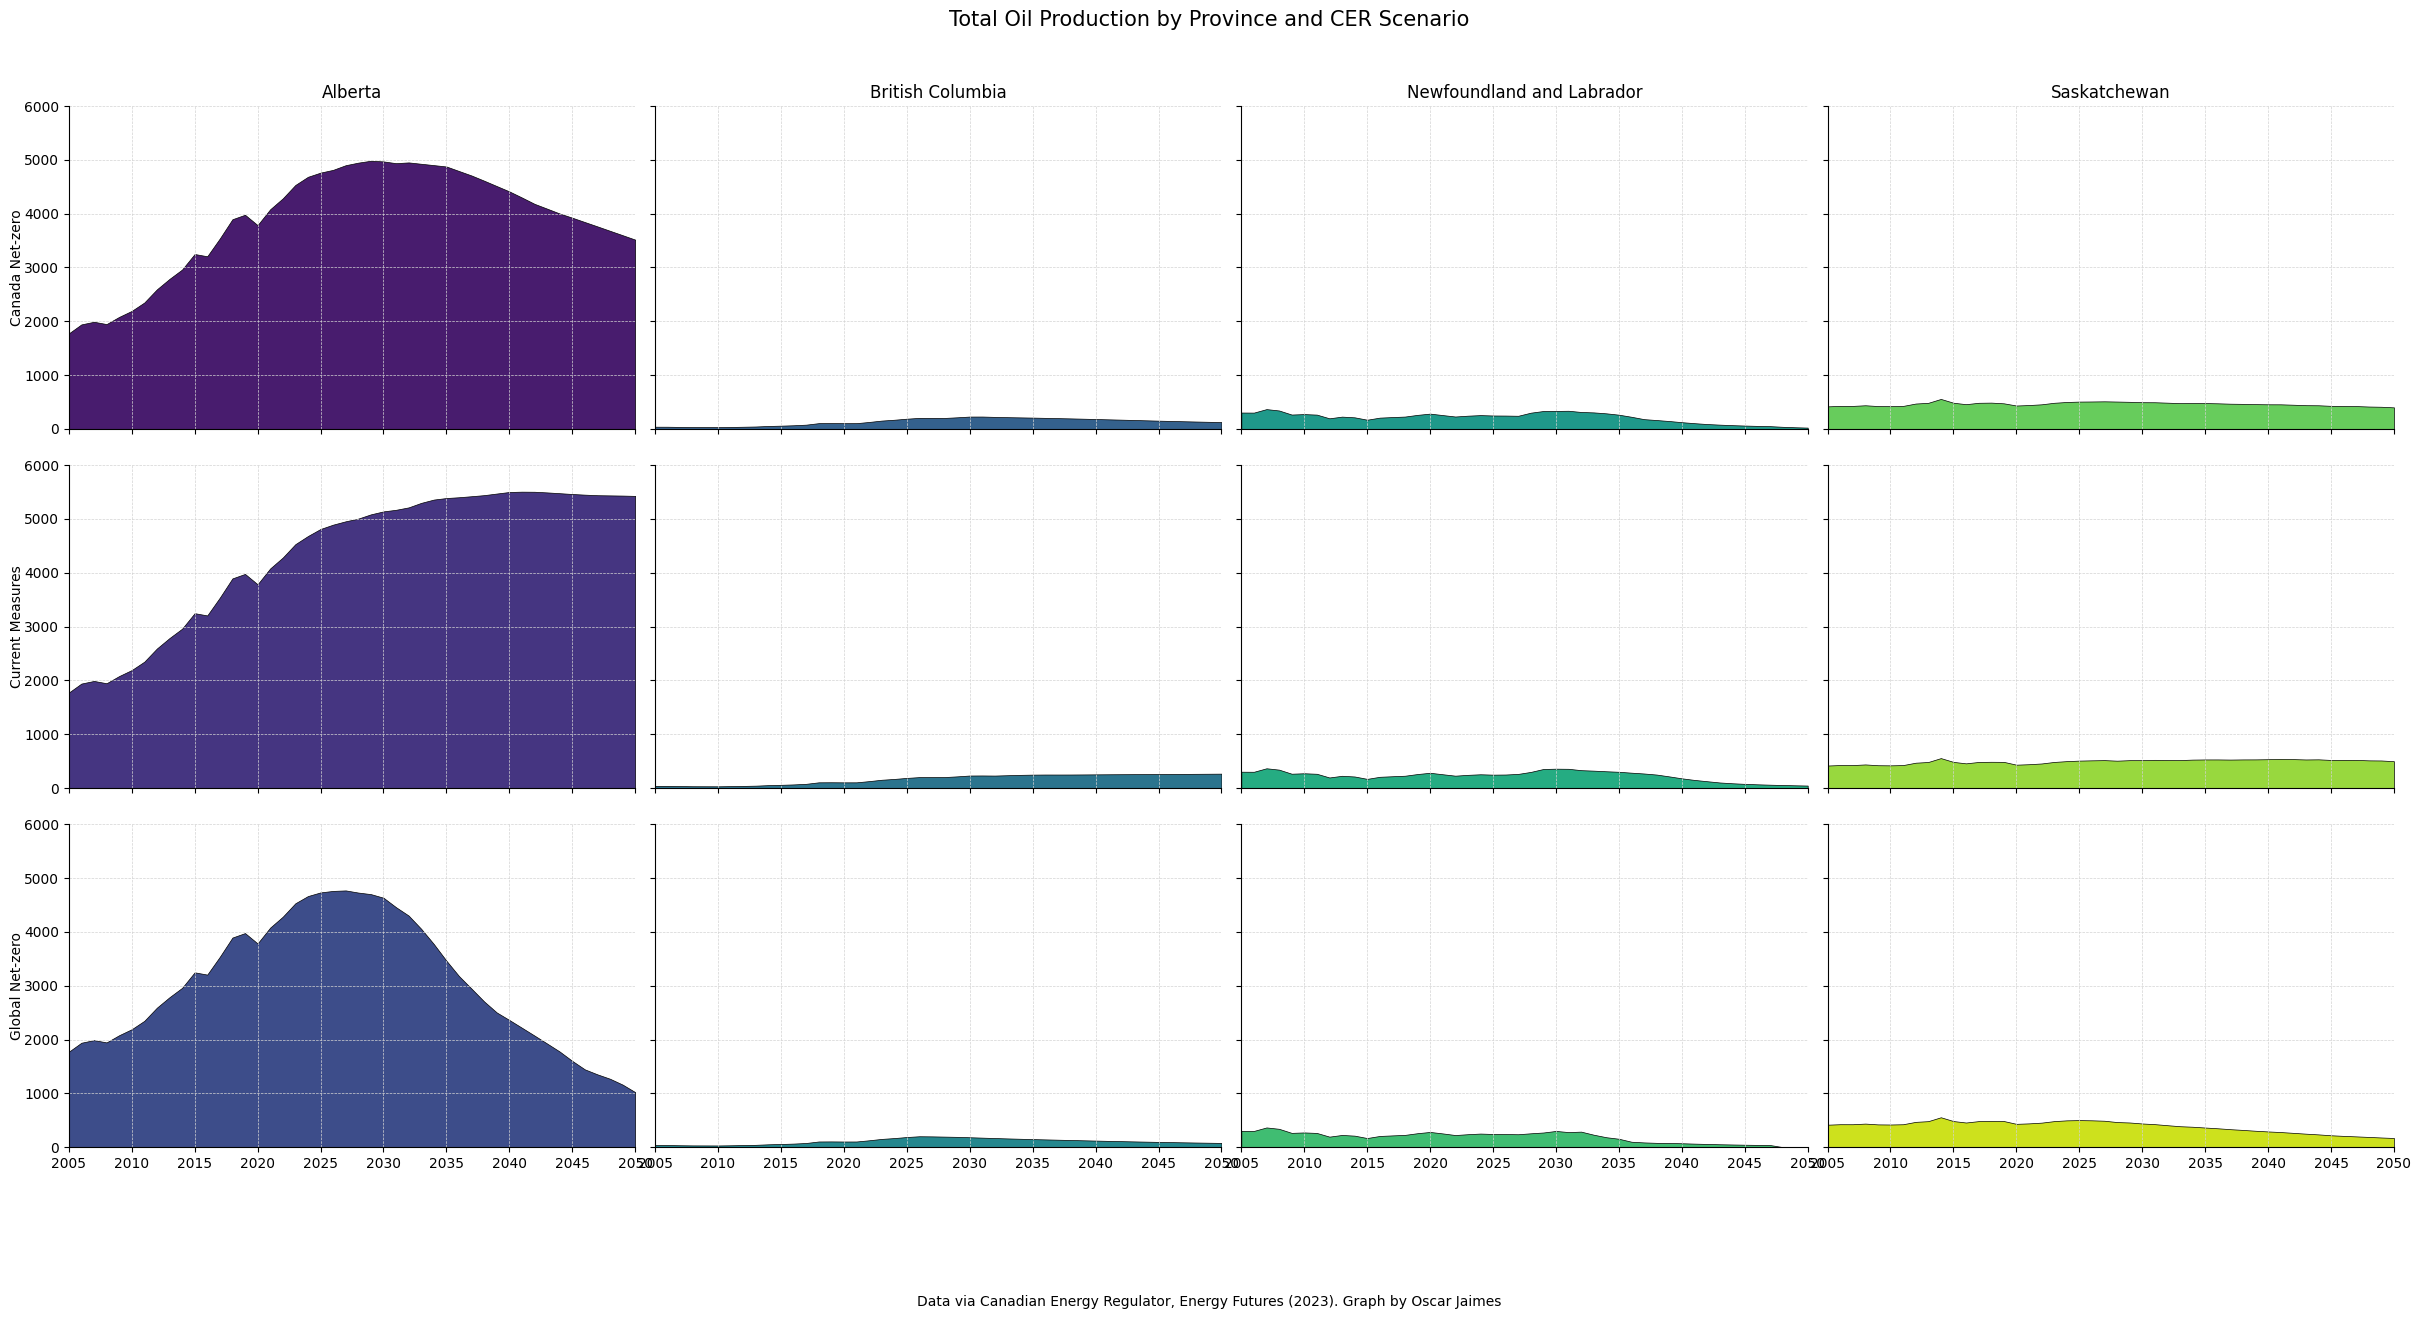

In [105]:
oil_regions = ["British Columbia", "Alberta", "Saskatchewan", "Newfoundland and Labrador"]

filtered_data = cer_crude[
    (cer_crude['Variable'] == "Total") &
    (cer_crude['Unit'] == "Thousand Barrels per day") &
    cer_crude['Region'].isin(oil_regions)
]

unique_combinations = filtered_data[['Region', 'Scenario']].drop_duplicates()
palette = sns.color_palette("viridis", n_colors=unique_combinations.shape[0])
color_dict = {tuple(row): color for row, color in zip(unique_combinations.values, palette)}

def draw_stacked_area(data, **kwargs):
    region = data['Region'].iloc[0]
    scenario = data['Scenario'].iloc[0]
    color = color_dict[(region, scenario)]
    
    x = data['Year'].unique()
    y = data['Value'].values
    plt.fill_between(x, y, color=color, edgecolor='black', linewidth=0.5)


# Plotting
g = sns.FacetGrid(filtered_data, row='Scenario', col='Region', height=4, aspect=1.5)
g.map_dataframe(draw_stacked_area)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Additional aesthetics using matplotlib
g.fig.suptitle('Total Oil Production by Province and CER Scenario', size=15)
plt.subplots_adjust(top=0.9)
g.set_axis_labels("", "Production (Thousands bbl/d)")
g.set(xlim=(filtered_data['Year'].min(), filtered_data['Year'].max()))
g.set(ylim=(0, 6000))

# Only set titles for top row (region names)
for ax, title in zip(g.axes[0], g.col_names):
    ax.set_title(title)

# Clear titles for other rows
for row_axes in g.axes[1:]:
    for ax in row_axes:
        ax.set_title('')

# Set scenario names for rows
for ax, title in zip(g.axes[:, 0], g.row_names):
    ax.set_ylabel(title, rotation=90, labelpad=5, va='center')

# Fine-tune appearance
for ax in g.axes.flat:
    ax.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)

# Caption
g.fig.text(0.5, -0.1, 'Data via Canadian Energy Regulator, Energy Futures (2023). Graph by Oscar Jaimes',
           ha='center')

# Fine-tune appearance using matplotlib
for ax in g.axes.flat:
    ax.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)

# Show plot
plt.show()